In [4]:
import os
import io
import random
import fnmatch
from csv import DictWriter
import pandas as pd

import pdb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from deap import base, creator, tools
import math

1 Name: Mavrovouniotis Menelaou Instances Test: 1 

2 COMMENT: Modificatification of E-n22-k4 instance. Modified by Mavrovouniotis Menelaou.

3 TYPE: EVRP 

4 OPTIMAL_VALUE: 384.678035 

5 VEHICLES: 4 

6 DIMENSION: 22 

7 STATIONS: 8 

8 CAPACITY: 6000 

9 ENERGY_CAPACITY: 94 

10 ENERGY_CONSUMPTION: 1.20 

11 EDGE_WEIGHT_FORMAT: EUC_2D

12 NODE_COORD_SECTION 

13 1 145 215 

14 2 151 264 

15 3 159 261 

16 4 130 254 

17 5 128 252 

18 6 163 247 

19 7 146 246 

20 8 161 242 

21 9 142 239 

22 10 163 236 

23 11 148 232 

24 12 128 231 

25 13 156 217 

26 14 129 214 

27 15 146 208 

28 16 164 208 

29 17 141 206 

30 18 147 193 

31 19 164 193 

32 20 129 189 

33 21 155 185 

34 22 139 182 

35 23 137 193 

36 24 137 213 

37 25 137 234 

38 26 137 254 

39 27 155 193 

40 28 155 213 

41 29 155 234 

42 30 155 254 

43 DEMAND_SECTION 

44 1 0

45 2 1100

46 3 700

47 4 800

48 5 1400

49 6 2100

50 7 400

51 8 800

52 9 100

53 10 500

54 11 600

55 12 1200

56 13 1300

57 14 1

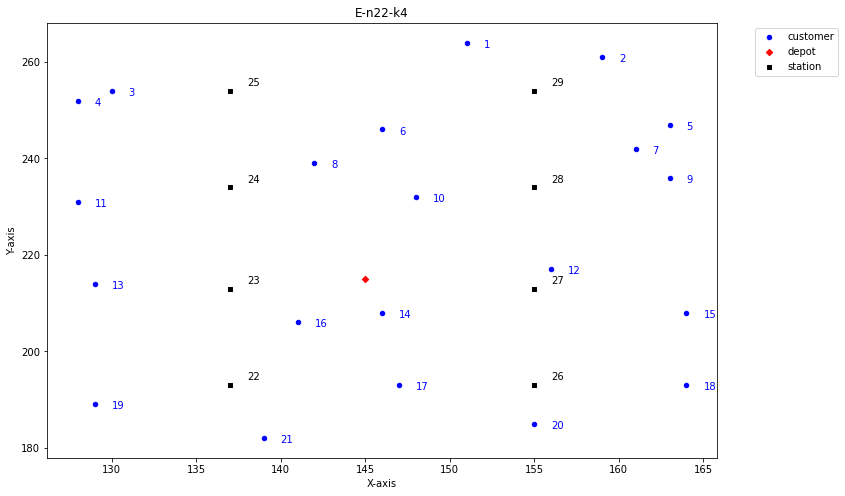

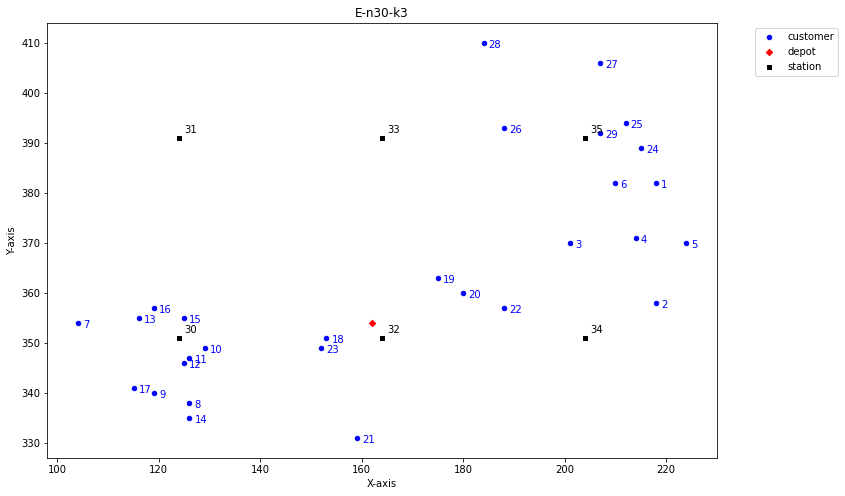

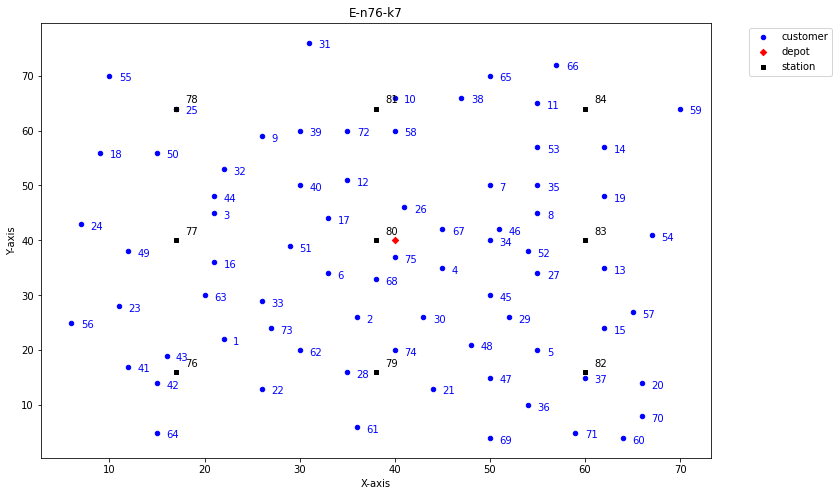

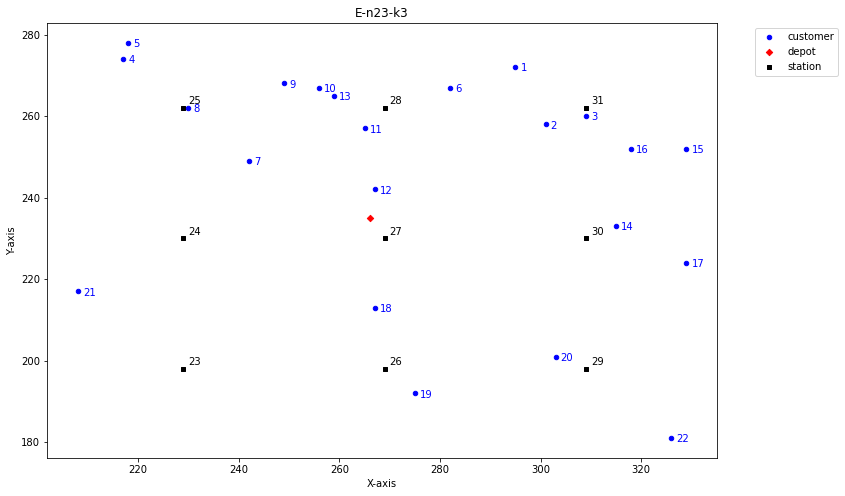

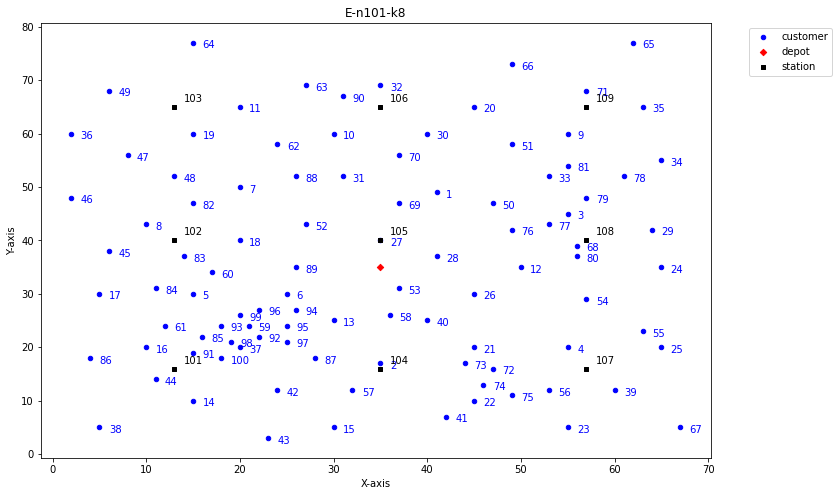

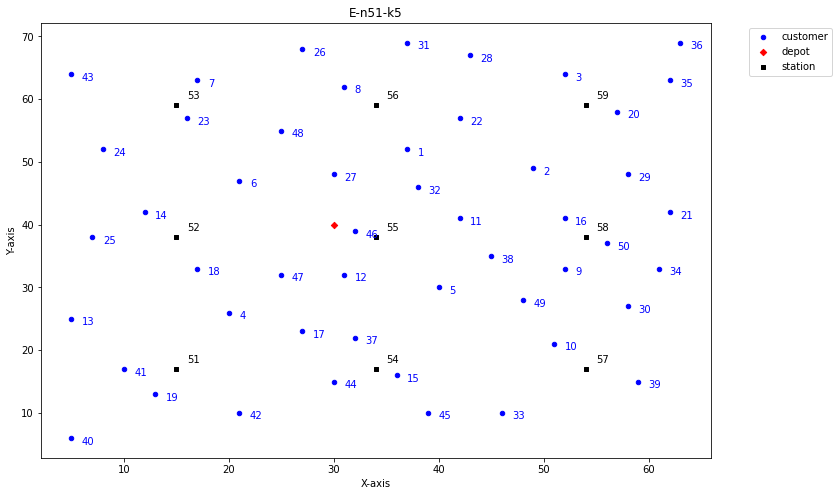

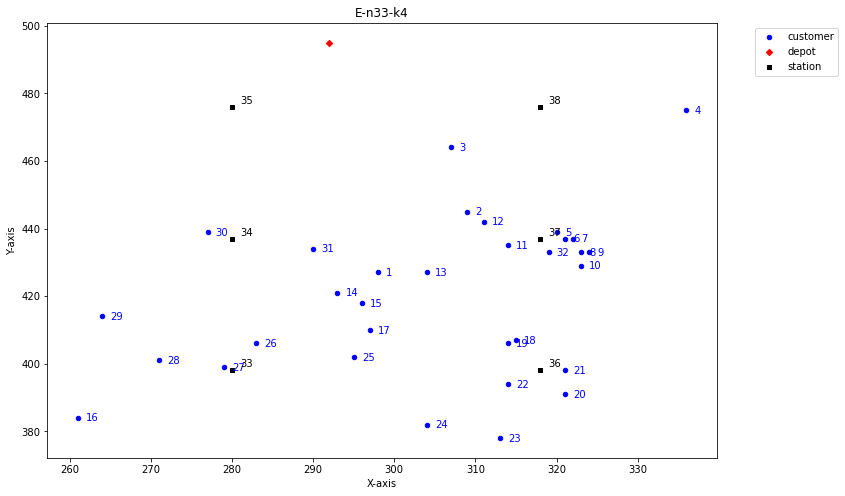

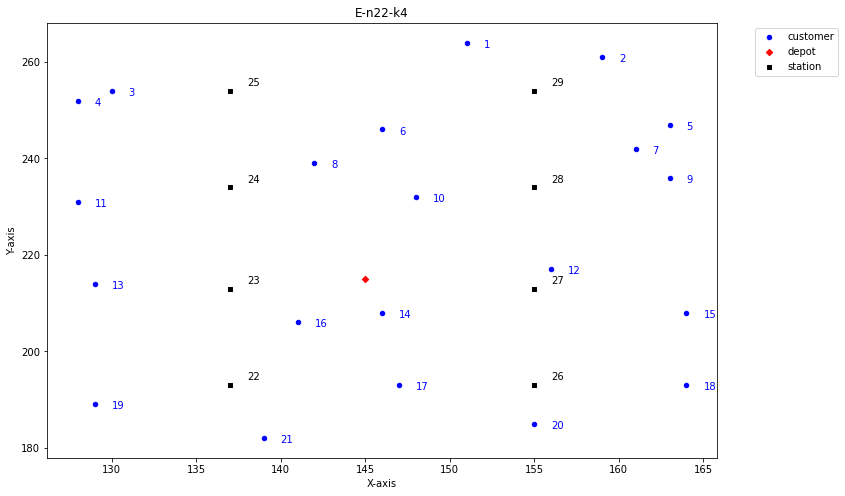

In [5]:
%run read_data.ipynb

In [7]:
BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
data_dir = os.path.join(BASE_DIR, 'evrp-benchmark-set')
result_dir = os.path.join(BASE_DIR, 'results')

In [6]:
instance.__dict__

{'filename': '/data/home/exx866/EVRP-WCCI-2020/evrp-benchmark-set/E-n22-k4.evrp',
 'name': 'E-n22-k4',
 'optimum': 384.678035,
 'num_of_vehicles': 4,
 'dimension': 22,
 'num_of_stations': 8,
 'capacity': 6000,
 'battery_capacity': 94,
 'energy_consumption': 1.2,
 'edge_weight_format': 'EUC_2D',
 'node_coordinates': {'0': [145, 215],
  '1': [151, 264],
  '2': [159, 261],
  '3': [130, 254],
  '4': [128, 252],
  '5': [163, 247],
  '6': [146, 246],
  '7': [161, 242],
  '8': [142, 239],
  '9': [163, 236],
  '10': [148, 232],
  '11': [128, 231],
  '12': [156, 217],
  '13': [129, 214],
  '14': [146, 208],
  '15': [164, 208],
  '16': [141, 206],
  '17': [147, 193],
  '18': [164, 193],
  '19': [129, 189],
  '20': [155, 185],
  '21': [139, 182],
  '22': [137, 193],
  '23': [137, 213],
  '24': [137, 234],
  '25': [137, 254],
  '26': [155, 193],
  '27': [155, 213],
  '28': [155, 234],
  '29': [155, 254]},
 'demands': {'0': 0,
  '1': 1100,
  '2': 700,
  '3': 800,
  '4': 1400,
  '5': 2100,
  '6': 40

## GA Implementation
-----
### Individual (Chromosome) encoding
* `0 - 5 - 6 - 8 - 0 - 1 - 2 - 3 - 4 - 0 - 7 - 0`
* there are many methods to generate the individual, for example, Density-Based Clustering Algorithm to partition the set in advance

### Individual initialization

1. generate individual without capacity violation
    * evenly
    * randomly
    * approach proposed by David & Viktor (manuscript)
2. make the individual feasible w.r.t energy consumption, otherwise discard these infeasible individuals. 
we can use Relaxed ZGA repair procedure.



In [8]:
def generate_individual_evenly(num_vehicles, num_customers, capacity, demands):
    """Generate an individual by distributing customers evenly across vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        capacity: The capacity of the vehicles.
        demands: The dictionary containing the demands of each customer.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """

    # Create a list of customer numbers and shuffle it
    customers = list(range(1, num_customers + 1))

    # Initialize the individual
    individual = []

    # Iterate until all routes satisfy the capacity constraint
    while not individual or any(capacity < sum(demands[f'{_}'] for _ in route) for route in individual):
        random.shuffle(customers)
        individual = [customers[i::num_vehicles] for i in range(num_vehicles)]
    
    return individual


def generate_individual_randomly(num_vehicles, num_customers, capacity, demands):
    """Generate an individual by randomly assigning customers to vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        capacity: The capacity of the vehicles.
        demands: The dictionary containing the demands of each customer.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """
    
    # Initialize an empty individual with a list for each vehicle
    individual = [[] for _ in range(num_vehicles)]
    
    # Create a list of customers and shuffle it
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)
    
    for customer in customers:
        assigned = False
        remaining_vehicles = list(range(num_vehicles))
        random.shuffle(remaining_vehicles)
        
        # Try to assign the customer to a random vehicle
        while not assigned and remaining_vehicles:
            vehicle = remaining_vehicles.pop()
            total_demand = sum(demands[f'{_}'] for _ in individual[vehicle]) + demands[f'{customer}']
            
            # Check if the customer can be assigned to the current vehicle
            if capacity >= total_demand:
                individual[vehicle].append(customer)
                assigned = True

        # If the customer is still not assigned, call the function recursively
        if not assigned:
            return generate_individual_randomly(num_vehicles, num_customers, capacity, demands)
    
    return individual

In [11]:
num_vehicles =  instance.num_of_vehicles
num_customers = instance.dimension - 1
capacity = instance.capacity
demands = instance.demands

individual = generate_individual_evenly(num_vehicles, num_customers, capacity, demands)
print(individual)

individual = generate_individual_randomly(num_vehicles, num_customers, capacity, demands)
print(individual)


[[17, 21, 20, 3, 7, 10], [18, 1, 19, 15, 8], [12, 14, 9, 5, 11], [13, 16, 2, 6, 4]]
[[20, 17, 16, 14], [10, 11, 8, 9, 4, 5], [12, 6, 19, 7, 21], [15, 3, 13, 18, 1, 2]]
